# Here I will be bring in data to investigate if one can look at Elon Musk's tweets, and based on what he tweets about, predict if they will become successful by breaching a certain threshold for replies, retweets, and likes.  I initialy intended to study the changes in stock prices based off of Elon's tweets, but due to time, I had cut that out.  Future work on this may allow me to do so, but that is for future work.

## Import all the libraries that are needed for this section:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_colwidth = 350
pd.options.display.max_columns = 999

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Bring in a dataset of Elon Musk's tweets from 2015 to 2020

In [2]:
tweets = pd.read_csv('data/elonmusk.csv')
tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1282939902531796993,1282933079431151618,1594711683000,2020-07-14,07:28:03,UTC,44196397,elonmusk,Elon Musk,NaN,Cute,['teslarati'],[],[],222,176,7883,[],[],https://twitter.com/elonmusk/status/1282939902531796993,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '1308211178', 'username': 'Teslarati'}]",NaN,NaN,NaN,NaN
1,1282844872571904000,1282801938111791104,1594689026000,2020-07-14,01:10:26,UTC,44196397,elonmusk,Elon Musk,NaN,Wow,"['davidtayar5', 'teslalisa', 'stevehamel16', 'vincent13031925', 's_padival', 'barkmsmeagol', 'annerajb', 'pjhornak', 'wpipperger', 'ecoheliguy']",[],[],346,180,4241,[],[],https://twitter.com/elonmusk/status/1282844872571904000,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '275295731', 'username': 'davidtayar5'}, {'user_id': '1046173159580479490', 'username': 'TeslaLisa'}, {'user_id': '999632398525530114', 'username': 'SteveHamel16'}, {'user_id': '1689516060', 'username': 'vincent13031925'}, {'user_id': '717042249624854529', 'username': 'S_Padival'}, {...",NaN,NaN,NaN,NaN
2,1282805559834492929,1282758532312584193,1594679653000,2020-07-13,22:34:13,UTC,44196397,elonmusk,Elon Musk,NaN,Reusability is essential. A rocket that is single use is just as absurd as a single use airplane. F9 engines already fire 3 times per flight.,['katlinegrey'],[],[],102,126,1551,[],[],https://twitter.com/elonmusk/status/1282805559834492929,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '319128454', 'username': 'katlinegrey'}]",NaN,NaN,NaN,NaN
3,1282800187308572672,1282671714657157120,1594678372000,2020-07-13,22:12:52,UTC,44196397,elonmusk,Elon Musk,NaN,Wild times!,['vincent13031925'],[],[],438,415,13421,[],[],https://twitter.com/elonmusk/status/1282800187308572672,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '1689516060', 'username': 'vincent13031925'}]",NaN,NaN,NaN,NaN
4,1282800078000803840,1282739486816964615,1594678346000,2020-07-13,22:12:26,UTC,44196397,elonmusk,Elon Musk,NaN,We’re being extra paranoid. Maximizing probability of successful launch is paramount.,['spaceflightnow'],[],[],128,155,4238,[],[],https://twitter.com/elonmusk/status/1282800078000803840,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '17217640', 'username': 'SpaceflightNow'}]",NaN,NaN,NaN,NaN


In [3]:
tweets.shape

(9286, 34)

In [4]:
tweets.isnull().sum()

id                    0
conversation_id       0
created_at            0
date                  0
time                  0
timezone              0
user_id               0
username              0
name                  0
place              9286
tweet                 0
mentions              0
urls                  0
photos                0
replies_count         0
retweets_count        0
likes_count           0
hashtags              0
cashtags              0
link                  0
retweet               0
quote_url          8931
video                 0
near               9286
geo                9286
source             9286
user_rt_id         9286
user_rt            9286
retweet_id         9286
reply_to              0
retweet_date       9286
translate          9286
trans_src          9286
trans_dest         9286
dtype: int64

In [5]:
tweets['retweet'].value_counts()

False    9286
Name: retweet, dtype: int64

There are no retweets from Elon

Try to use the fact that maybe some url and video contents may influence interactions
Do tweets with links and videos, or both, have more engagement?

In [6]:
tweets[tweets['quote_url'].notnull()]

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
115,1279275487877951488,1279275487877951488,1593838018000,2020-07-04,04:46:58,UTC,44196397,elonmusk,Elon Musk,NaN,Congrats Tesla Team — U ROK!! https://twitter.com/vincent13031925/status/1278671904207892480 …,[],['https://twitter.com/vincent13031925/status/1278671904207892480'],[],3524,1706,38850,[],[],https://twitter.com/elonmusk/status/1279275487877951488,False,https://twitter.com/vincent13031925/status/1278671904207892480,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
153,1278782112074735617,1278782112074735617,1593720388000,2020-07-02,20:06:28,UTC,44196397,elonmusk,Elon Musk,NaN,Thanks Tesla owners & investors! Love you!! We will work super hard to earn your trust & support. https://twitter.com/Tesla/status/1278757900568023041 …,[],['https://twitter.com/Tesla/status/1278757900568023041'],[],3707,2924,43987,[],[],https://twitter.com/elonmusk/status/1278782112074735617,False,https://twitter.com/Tesla/status/1278757900568023041,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
207,1278085116338884608,1278085116338884608,1593554212000,2020-06-30,21:56:52,UTC,44196397,elonmusk,Elon Musk,NaN,Your GPS just got slightly better https://twitter.com/SpaceX/status/1278081295608766464 …,[],['https://twitter.com/SpaceX/status/1278081295608766464'],[],2941,13306,168990,[],[],https://twitter.com/elonmusk/status/1278085116338884608,False,https://twitter.com/SpaceX/status/1278081295608766464,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
230,1276568125060689924,1276568125060689924,1593192533000,2020-06-26,17:28:53,UTC,44196397,elonmusk,Elon Musk,NaN,.@JeffBezos is a copy 🐈 haha https://twitter.com/FT/status/1276401808068526080 …,['jeffbezos'],['https://twitter.com/FT/status/1276401808068526080'],[],6611,27923,253773,[],[],https://twitter.com/elonmusk/status/1276568125060689924,False,https://twitter.com/FT/status/1276401808068526080,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '15506669', 'username': 'JeffBezos'}]",NaN,NaN,NaN,NaN
335,1272972228326379520,1272972228326379520,1592335204000,2020-06-16,19:20:04,UTC,44196397,elonmusk,Elon Musk,NaN,"SpaceX is building floating, superheavy-class spaceports for Mars, moon & hypersonic travel around Earth https://twitter.com/SpaceXFleet/status/1272891684070871045 …",[],['https://twitter.com/SpaceXFleet/status/1272891684070871045'],[],3671,10073,83819,[],[],https://twitter.com/elonmusk/status/1272972228326379520,False,https://twitter.com/SpaceXFleet/status/1272891684070871045,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9125,647939356548730882,647939356548730882,1443315755000,2015-09-27,01:02:35,UTC,44196397,elonmusk,Elon Musk,NaN,Great discussion about solar/batteries empowering rural communities https://twitter.com/pmoindia/status/647901659033501697 …,[],['https://twitter.com/pmoindia/status/647901659033501697'],[],130,1573,1828,[],[],https://twitter.com/elonmusk/status/647939356548730882,False,https://twitter.com/PMOIndia/status/647901659033501697,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
9142,635214915934928896,635214915934928896,1440282012000,2015-08-22,22:20:12,UTC,44196397,elonmusk,Elon Musk,NaN,"True, but achieving a long range affordable electric vehicle has always been our long-term goal. Due in late 2017! https://twitter.com/forbes/status/634111598387404800 …",[],['https://twitter.com/forb

In [7]:
tweets[tweets['quote_url'].notnull()]['likes_count']

115      38850
153      43987
207     168990
230     253773
335      83819
         ...  
9125      1828
9142      2590
9144      1539
9146      2949
9170      1712
Name: likes_count, Length: 355, dtype: int64

In [8]:
tweets[tweets['quote_url'].notnull()]['replies_count']

115     3524
153     3707
207     2941
230     6611
335     3671
        ... 
9125     130
9142     233
9144     143
9146     349
9170     151
Name: replies_count, Length: 355, dtype: int64

In [9]:
tweets[tweets['quote_url'].notnull()]['retweets_count']

115      1706
153      2924
207     13306
230     27923
335     10073
        ...  
9125     1573
9142     1436
9144      879
9146     2317
9170     1250
Name: retweets_count, Length: 355, dtype: int64

In [10]:
tweets['retweet'].value_counts()

False    9286
Name: retweet, dtype: int64

In [11]:
tweets['video'].value_counts()

0    9216
1      70
Name: video, dtype: int64

## There are not many tweets with videos, but they do have high traffic

In [12]:
tweets[tweets['video'] == 1]

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
479,1265315536084369408,1265315536084369408,1590509706000,2020-05-26,16:15:06,UTC,44196397,elonmusk,Elon Musk,NaN,Dragon Dawn pic.twitter.com/mz1EzU5GSO,[],[],[],3129,20095,171859,[],[],https://twitter.com/elonmusk/status/1265315536084369408,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
872,1254632509863866368,1254618912785915906,1587962674000,2020-04-27,04:44:34,UTC,44196397,elonmusk,Elon Musk,NaN,SN4 passed cryo proof! 😅 pic.twitter.com/EJakThZRGF,[],[],[],1097,2523,30814,[],[],https://twitter.com/elonmusk/status/1254632509863866368,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
875,1254618912785915906,1254618912785915906,1587959433000,2020-04-27,03:50:33,UTC,44196397,elonmusk,Elon Musk,NaN,Snowing in Texas pic.twitter.com/0LKwIpnoPB,[],[],[],1623,4634,74712,[],[],https://twitter.com/elonmusk/status/1254618912785915906,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1141,1247340041552068609,1247333596097998848,1586224015000,2020-04-07,01:46:55,UTC,44196397,elonmusk,Elon Musk,NaN,High pucker-factor landing pic.twitter.com/cTHxc03Oee,['johnkrausphotos'],[],[],511,1879,17914,[],[],https://twitter.com/elonmusk/status/1247340041552068609,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '3072160164', 'username': 'johnkrausphotos'}]",NaN,NaN,NaN,NaN
1142,1247333596097998848,1247333596097998848,1586222478000,2020-04-07,01:21:18,UTC,44196397,elonmusk,Elon Musk,NaN,Here you go https://twitter.com/_AndrewwG_/status/1247024088733724672 … pic.twitter.com/aVnwR0loX9,[],['https://twitter.com/_AndrewwG_/status/1247024088733724672'],[],1999,12295,90904,[],[],https://twitter.com/elonmusk/status/1247333596097998848,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8270,812463378270588928,812463378270588928,1482541338000,2016-12-24,01:02:18,UTC,44196397,elonmusk,Elon Musk,NaN,"To activate the Model X holiday performance, just type holidays or ModelXmas after pressing the logo. Also, Mars. pic.twitter.com/8Cy7YPlECX",[],[],[],510,4613,15160,[],[],https://twitter.com/elonmusk/status/812463378270588928,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
8293,807354766804168706,807354766804168706,1481323350000,2016-12-09,22:42:30,UTC,44196397,elonmusk,Elon Musk,NaN,Forming a rocket nozzle pic.twitter.com/QrpcVyHAXr,[],[],[],791,11768,33775,[],[],https://twitter.com/elonmusk/status/807354766804168706,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
8564,755140683112017920,755140683112017920,1468874543000,2016-07-18,20:42:23,UTC,44196397,elonmusk,Elon Musk,NaN,Landing pic.twitter.com/dRWGyyTtCH,[],[],[],258,3304,10229,[],[],https://twitter.com/elonmusk/status/755140683112017920,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
8667,743602894226653184,743602894226653184,1466123720000,2016-06-17,00:35:20,UTC,44196397,elonmusk,Elon Musk,NaN,Looks like early liquid oxygen depletion caused engine shutdown just above the deck pic.twitter.com/Sa6uCkpknY,[],[],[],655,5193,11217,[],[],https://twitter.com/elonmusk/status/743602894226653184,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN


In [56]:
tweets[tweets['video'] == 1].sort_values(by='retweets_count', ascending=False).head(60)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
7009,960992715579125760,960992715579125760,1517953492000,2018-02-06,21:44:52,UTC,44196397,elonmusk,Elon Musk,NaN,"View from SpaceX Launch Control. Apparently, there is a car in orbit around Earth. pic.twitter.com/QljN2VnL1O",[],[],[],12705,157197,452263,[],[],https://twitter.com/elonmusk/status/960992715579125760,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
2141,1198751258384818176,1198751258384818176,1574639546000,2019-11-24,23:52:26,UTC,44196397,elonmusk,Elon Musk,NaN,Cybertruck pulls F-150 uphill pic.twitter.com/OfaqUkrDI3,[],[],[],15985,113395,656704,[],[],https://twitter.com/elonmusk/status/1198751258384818176,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7119,944399853316055040,944399853316055040,1513997445000,2017-12-23,02:50:45,UTC,44196397,elonmusk,Elon Musk,NaN,Nuclear alien UFO from North Korea pic.twitter.com/GUIHpKkkp5,[],[],[],6216,88759,290548,[],[],https://twitter.com/elonmusk/status/944399853316055040,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
5905,1016063173139427329,1016063173139427329,1531083312000,2018-07-08,20:55:12,UTC,44196397,elonmusk,Elon Musk,NaN,pic.twitter.com/D1umiFDr1t,[],[],[],3904,49327,191366,[],[],https://twitter.com/elonmusk/status/1016063173139427329,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7368,902039243601485824,902039243601485824,1503897889000,2017-08-28,05:24:49,UTC,44196397,elonmusk,Elon Musk,NaN,Hyperloop pod run by team WARR pic.twitter.com/ntaMsoxkZE,[],[],[],3087,43301,120888,[],[],https://twitter.com/elonmusk/status/902039243601485824,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
2174,1198090787520598016,1198090787520598016,1574482077000,2019-11-23,04:07:57,UTC,44196397,elonmusk,Elon Musk,NaN,Franz throws steel ball at Cybertruck window right before launch. Guess we have some improvements to make before production haha. pic.twitter.com/eB0o4tlPoz,[],[],[],8233,37511,321949,[],[],https://twitter.com/elonmusk/status/1198090787520598016,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1856,1214483582363693057,1214483582363693057,1578390424000,2020-01-07,09:47:04,UTC,44196397,elonmusk,Elon Musk,NaN,At Tesla Giga Shanghai NSFW!! pic.twitter.com/1yrPyzJQGZ,[],[],[],7144,35743,299844,[],[],https://twitter.com/elonmusk/status/1214483582363693057,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
6920,972245615735222273,972233079342297088,1520636392000,2018-03-09,22:59:52,UTC,44196397,elonmusk,Elon Musk,NaN,"Better video coming soon, but it would look a bit like this: pic.twitter.com/C0iJPi8b4U",[],[],[],2707,28622,110349,[],[],https://twitter.com/elonmusk/status/972245615735222273,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
3064,1155567236716740608,1155567236716740608,1564343673000,2019-07-28,19:54:33,UTC,44196397,elonmusk,Elon Musk,NaN,Falcon rocket reentry from space with double sonic booms pic.twitter.com/6DDPjcOgQH,[],[],[],2729,24094,134939,[],[],https://twitter.com/elonmusk/status/1155567236716740608,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
3409,1142847732593258496,1142847732593258496,1561311107000,2019-06-23,17:31:47,UTC,44196397,elonmusk,Elon Musk,NaN,Anywhere can be paradise as long as you have the will to live.\n新世紀エヴァンゲリオン pic.twitter.com/bC2G5UYPzS,[],[],[],2620,23411,12

In [57]:
tweets[tweets['video'] == 1].sort_values(by='replies_count', ascending=False).head(60)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
2141,1198751258384818176,1198751258384818176,1574639546000,2019-11-24,23:52:26,UTC,44196397,elonmusk,Elon Musk,NaN,Cybertruck pulls F-150 uphill pic.twitter.com/OfaqUkrDI3,[],[],[],15985,113395,656704,[],[],https://twitter.com/elonmusk/status/1198751258384818176,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7009,960992715579125760,960992715579125760,1517953492000,2018-02-06,21:44:52,UTC,44196397,elonmusk,Elon Musk,NaN,"View from SpaceX Launch Control. Apparently, there is a car in orbit around Earth. pic.twitter.com/QljN2VnL1O",[],[],[],12705,157197,452263,[],[],https://twitter.com/elonmusk/status/960992715579125760,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
2174,1198090787520598016,1198090787520598016,1574482077000,2019-11-23,04:07:57,UTC,44196397,elonmusk,Elon Musk,NaN,Franz throws steel ball at Cybertruck window right before launch. Guess we have some improvements to make before production haha. pic.twitter.com/eB0o4tlPoz,[],[],[],8233,37511,321949,[],[],https://twitter.com/elonmusk/status/1198090787520598016,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1856,1214483582363693057,1214483582363693057,1578390424000,2020-01-07,09:47:04,UTC,44196397,elonmusk,Elon Musk,NaN,At Tesla Giga Shanghai NSFW!! pic.twitter.com/1yrPyzJQGZ,[],[],[],7144,35743,299844,[],[],https://twitter.com/elonmusk/status/1214483582363693057,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7119,944399853316055040,944399853316055040,1513997445000,2017-12-23,02:50:45,UTC,44196397,elonmusk,Elon Musk,NaN,Nuclear alien UFO from North Korea pic.twitter.com/GUIHpKkkp5,[],[],[],6216,88759,290548,[],[],https://twitter.com/elonmusk/status/944399853316055040,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
4890,1076081614562578432,1076081614562578432,1545392824000,2018-12-21,11:47:04,UTC,44196397,elonmusk,Elon Musk,NaN,💛 Bajirao Mastani 💛\n https://m.youtube.com/watch?v=h6lHUn20J5g … pic.twitter.com/DZyV6S7TJZ,[],['https://m.youtube.com/watch?v=h6lHUn20J5g'],[],4077,11658,60722,[],[],https://twitter.com/elonmusk/status/1076081614562578432,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
5905,1016063173139427329,1016063173139427329,1531083312000,2018-07-08,20:55:12,UTC,44196397,elonmusk,Elon Musk,NaN,pic.twitter.com/D1umiFDr1t,[],[],[],3904,49327,191366,[],[],https://twitter.com/elonmusk/status/1016063173139427329,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
4253,1107378575924035584,1107378575924035584,1552854601000,2019-03-17,20:30:01,UTC,44196397,elonmusk,Elon Musk,NaN,Testing Starship heatshield hex tiles pic.twitter.com/PycE9VthxQ,[],[],[],3398,11704,141312,[],[],https://twitter.com/elonmusk/status/1107378575924035584,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1818,1216198285792358400,1216198285792358400,1578799241000,2020-01-12,03:20:41,UTC,44196397,elonmusk,Elon Musk,NaN,Teslas will soon talk to people if you want. This is real. pic.twitter.com/8AJdERX5qa,[],[],[],3347,14237,156957,[],[],https://twitter.com/elonmusk/status/1216198285792358400,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
479,1265315536084369408,1265315536084369408,1590509706000,2020-05-26,16:15:06,UTC,44196397,elonmusk,Elon Musk,NaN,Dragon Dawn pic.twitter.com/mz1EzU5GSO,[],[],[],3129,20095,171859,

In [55]:
tweets[tweets['video'] == 1].sort_values(by='likes_count', ascending=False).head(60)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
2141,1198751258384818176,1198751258384818176,1574639546000,2019-11-24,23:52:26,UTC,44196397,elonmusk,Elon Musk,NaN,Cybertruck pulls F-150 uphill pic.twitter.com/OfaqUkrDI3,[],[],[],15985,113395,656704,[],[],https://twitter.com/elonmusk/status/1198751258384818176,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7009,960992715579125760,960992715579125760,1517953492000,2018-02-06,21:44:52,UTC,44196397,elonmusk,Elon Musk,NaN,"View from SpaceX Launch Control. Apparently, there is a car in orbit around Earth. pic.twitter.com/QljN2VnL1O",[],[],[],12705,157197,452263,[],[],https://twitter.com/elonmusk/status/960992715579125760,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
2174,1198090787520598016,1198090787520598016,1574482077000,2019-11-23,04:07:57,UTC,44196397,elonmusk,Elon Musk,NaN,Franz throws steel ball at Cybertruck window right before launch. Guess we have some improvements to make before production haha. pic.twitter.com/eB0o4tlPoz,[],[],[],8233,37511,321949,[],[],https://twitter.com/elonmusk/status/1198090787520598016,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1856,1214483582363693057,1214483582363693057,1578390424000,2020-01-07,09:47:04,UTC,44196397,elonmusk,Elon Musk,NaN,At Tesla Giga Shanghai NSFW!! pic.twitter.com/1yrPyzJQGZ,[],[],[],7144,35743,299844,[],[],https://twitter.com/elonmusk/status/1214483582363693057,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7119,944399853316055040,944399853316055040,1513997445000,2017-12-23,02:50:45,UTC,44196397,elonmusk,Elon Musk,NaN,Nuclear alien UFO from North Korea pic.twitter.com/GUIHpKkkp5,[],[],[],6216,88759,290548,[],[],https://twitter.com/elonmusk/status/944399853316055040,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
5905,1016063173139427329,1016063173139427329,1531083312000,2018-07-08,20:55:12,UTC,44196397,elonmusk,Elon Musk,NaN,pic.twitter.com/D1umiFDr1t,[],[],[],3904,49327,191366,[],[],https://twitter.com/elonmusk/status/1016063173139427329,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
479,1265315536084369408,1265315536084369408,1590509706000,2020-05-26,16:15:06,UTC,44196397,elonmusk,Elon Musk,NaN,Dragon Dawn pic.twitter.com/mz1EzU5GSO,[],[],[],3129,20095,171859,[],[],https://twitter.com/elonmusk/status/1265315536084369408,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1818,1216198285792358400,1216198285792358400,1578799241000,2020-01-12,03:20:41,UTC,44196397,elonmusk,Elon Musk,NaN,Teslas will soon talk to people if you want. This is real. pic.twitter.com/8AJdERX5qa,[],[],[],3347,14237,156957,[],[],https://twitter.com/elonmusk/status/1216198285792358400,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
4580,1092270756715737088,1092268892339273730,1549252616000,2019-02-04,03:56:56,UTC,44196397,elonmusk,Elon Musk,NaN,pic.twitter.com/ChEGbjTGKZ,[],[],[],2616,20915,150794,[],[],https://twitter.com/elonmusk/status/1092270756715737088,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
4253,1107378575924035584,1107378575924035584,1552854601000,2019-03-17,20:30:01,UTC,44196397,elonmusk,Elon Musk,NaN,Testing Starship heatshield hex tiles pic.twitter.com/PycE9VthxQ,[],[],[],3398,11704,141312,[],[],https://twitter.com/elonmusk/status/1107378575924035584,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_i

In [58]:
tweets.sort_values(by=('retweets_count'), ascending=False).head(60)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
5339,1053390822991790083,1053390822991790083,1539982917000,2018-10-19,21:01:57,UTC,44196397,elonmusk,Elon Musk,NaN,Had to been done ur welcome pic.twitter.com/7jT0f9lqIS,[],[],['https://pbs.twimg.com/media/Dp5lXiYUUAAngKq.jpg'],18387,384289,1252708,[],[],https://twitter.com/elonmusk/status/1053390822991790083,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1437,1236029449042198528,1236029449042198528,1583527359000,2020-03-06,20:42:39,UTC,44196397,elonmusk,Elon Musk,NaN,The coronavirus panic is dumb,[],[],[],45460,328882,1682551,[],[],https://twitter.com/elonmusk/status/1236029449042198528,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7788,870369915894546432,870369915894546432,1496347333000,2017-06-01,20:02:13,UTC,44196397,elonmusk,Elon Musk,NaN,Am departing presidential councils. Climate change is real. Leaving Paris is not good for America or the world.,[],[],[],26151,206708,502853,[],[],https://twitter.com/elonmusk/status/870369915894546432,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
2079,1205030950750412800,1205030950750412800,1576136741000,2019-12-12,07:45:41,UTC,44196397,elonmusk,Elon Musk,NaN,"If life is a video game, the graphics are great, but the plot is confusing & the tutorial is way too long",[],[],[],10856,178771,773835,[],[],https://twitter.com/elonmusk/status/1205030950750412800,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
3143,1153078534916587520,1153078534916587520,1563750320000,2019-07-21,23:05:20,UTC,44196397,elonmusk,Elon Musk,NaN,"Technically, alcohol is a solution",[],[],[],6175,169152,611862,[],[],https://twitter.com/elonmusk/status/1153078534916587520,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
435,1269163651958595584,1269160682852880386,1591427169000,2020-06-06,07:06:09,UTC,44196397,elonmusk,Elon Musk,NaN,"Selling weed literally went from major felony to essential business (open during pandemic) in much of America & yet many are still in prison. Doesn’t make sense, isn’t right.",[],[],[],13182,164899,733439,[],[],https://twitter.com/elonmusk/status/1269163651958595584,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
92,1279585827350122496,1279585827350122496,1593912009000,2020-07-05,01:20:09,UTC,44196397,elonmusk,Elon Musk,NaN,pic.twitter.com/jAmuz6NaA4,[],[],['https://pbs.twimg.com/media/EcIAhuvUcAAIh1M.jpg'],17967,161093,740773,[],[],https://twitter.com/elonmusk/status/1279585827350122496,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
4786,1080963075539234816,1080963075539234816,1546556655000,2019-01-03,23:04:15,UTC,44196397,elonmusk,Elon Musk,NaN,There are no coincidences pic.twitter.com/9AEbbuXZGn,[],[],['https://pbs.twimg.com/media/DwBaLg6VYAAMeaJ.jpg'],6377,157805,653642,[],[],https://twitter.com/elonmusk/status/1080963075539234816,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7009,960992715579125760,960992715579125760,1517953492000,2018-02-06,21:44:52,UTC,44196397,elonmusk,Elon Musk,NaN,"View from SpaceX Launch Control. Apparently, there is a car in orbit around Earth. pic.twitter.com/QljN2VnL1O",[],[],[],12705,157197,452263,[],[],https://twitter.com/elonmusk/status/960992715579125760,False,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
236,1276396101872922625,1276396101872922625,1593151519000,2020-06-26,

In [59]:
tweets.sort_values(by=('replies_count'), ascending=False).head(60)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
852,1255380013488189440,1255380013488189440,1588140893000,2020-04-29,06:14:53,UTC,44196397,elonmusk,Elon Musk,NaN,FREE AMERICA NOW,[],[],[],49529,66849,367763,[],[],https://twitter.com/elonmusk/status/1255380013488189440,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
5282,1055517521082609664,1055517521082609664,1540489962000,2018-10-25,17:52:42,UTC,44196397,elonmusk,Elon Musk,NaN,Send me ur dankest memes!!,[],[],[],46768,63153,313707,[],[],https://twitter.com/elonmusk/status/1055517521082609664,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
1437,1236029449042198528,1236029449042198528,1583527359000,2020-03-06,20:42:39,UTC,44196397,elonmusk,Elon Musk,NaN,The coronavirus panic is dumb,[],[],[],45460,328882,1682551,[],[],https://twitter.com/elonmusk/status/1236029449042198528,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
823,1256239554148724737,1256239554148724737,1588345824000,2020-05-01,15:10:24,UTC,44196397,elonmusk,Elon Musk,NaN,I am selling almost all physical possessions. Will own no house.,[],[],[],37949,25287,279011,[],[],https://twitter.com/elonmusk/status/1256239554148724737,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
535,1262076474565242880,1262076474565242880,1589737454000,2020-05-17,17:44:14,UTC,44196397,elonmusk,Elon Musk,NaN,Take the red pill 🌹,[],[],[],35004,110623,551957,[],[],https://twitter.com/elonmusk/status/1262076474565242880,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
625,1259945593805221891,1259945593805221891,1589229412000,2020-05-11,20:36:52,UTC,44196397,elonmusk,Elon Musk,NaN,"Tesla is restarting production today against Alameda County rules. I will be on the line with everyone else. If anyone is arrested, I ask that it only be me.",[],[],[],34568,81121,527222,[],[],https://twitter.com/elonmusk/status/1259945593805221891,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
506,1263974008900382721,1263974008900382721,1590189861000,2020-05-22,23:24:21,UTC,44196397,elonmusk,Elon Musk,NaN,"Open your eyes, look up to the skies",[],[],[],26831,92051,652602,[],[],https://twitter.com/elonmusk/status/1263974008900382721,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
6058,1011672532838055937,1011672532838055937,1530036502000,2018-06-26,18:08:22,UTC,44196397,elonmusk,Elon Musk,NaN,"What would you love to see in a Tesla pickup truck? I have a few things in mind, but what do you think are small, but important nuances & what would be seriously next level?",[],[],[],26155,4648,52325,[],[],https://twitter.com/elonmusk/status/1011672532838055937,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
7788,870369915894546432,870369915894546432,1496347333000,2017-06-01,20:02:13,UTC,44196397,elonmusk,Elon Musk,NaN,Am departing presidential councils. Climate change is real. Leaving Paris is not good for America or the world.,[],[],[],26151,206708,502853,[],[],https://twitter.com/elonmusk/status/870369915894546432,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
449,1267650659320500226,1267650659320500226,1591066443000,2020-06-02,02:54:03,UTC,44196397,elonmusk,Elon Musk,NaN,Off Twitter for a while,[],[],[],24410,32363,568153,[],[],https://twitter.com/elonmusk/status/1267650659320500226,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397

In [60]:
tweets.sort_values(by=('likes_count'), ascending=False).head(60)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
1437,1236029449042198528,1236029449042198528,1583527359000,2020-03-06,20:42:39,UTC,44196397,elonmusk,Elon Musk,NaN,The coronavirus panic is dumb,[],[],[],45460,328882,1682551,[],[],https://twitter.com/elonmusk/status/1236029449042198528,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
5339,1053390822991790083,1053390822991790083,1539982917000,2018-10-19,21:01:57,UTC,44196397,elonmusk,Elon Musk,NaN,Had to been done ur welcome pic.twitter.com/7jT0f9lqIS,[],[],['https://pbs.twimg.com/media/Dp5lXiYUUAAngKq.jpg'],18387,384289,1252708,[],[],https://twitter.com/elonmusk/status/1053390822991790083,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
463,1266811094527508481,1266811094527508481,1590866275000,2020-05-30,19:17:55,UTC,44196397,elonmusk,Elon Musk,NaN,5 mins to T-0,[],[],[],18610,56137,902284,[],[],https://twitter.com/elonmusk/status/1266811094527508481,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
236,1276396101872922625,1276396101872922625,1593151519000,2020-06-26,06:05:19,UTC,44196397,elonmusk,Elon Musk,NaN,pic.twitter.com/e9dPKVSjjl,[],[],['https://pbs.twimg.com/media/EbarfO6U4AA-7c5.jpg'],7103,141842,891473,[],[],https://twitter.com/elonmusk/status/1276396101872922625,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
2079,1205030950750412800,1205030950750412800,1576136741000,2019-12-12,07:45:41,UTC,44196397,elonmusk,Elon Musk,NaN,"If life is a video game, the graphics are great, but the plot is confusing & the tutorial is way too long",[],[],[],10856,178771,773835,[],[],https://twitter.com/elonmusk/status/1205030950750412800,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
235,1276418907968925696,1276418907968925696,1593156957000,2020-06-26,07:35:57,UTC,44196397,elonmusk,Elon Musk,NaN,"Who controls the memes,\ncontrols the Universe",[],[],[],17120,125830,771411,[],[],https://twitter.com/elonmusk/status/1276418907968925696,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
3671,1129274835173908481,1129274835173908481,1558075076000,2019-05-17,06:37:56,UTC,44196397,elonmusk,Elon Musk,NaN,And I am forever grateful pic.twitter.com/kU1pT8t0yv,[],[],['https://pbs.twimg.com/media/D6v9ed6UwAAoKg2.jpg'],3368,140432,762929,[],[],https://twitter.com/elonmusk/status/1129274835173908481,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
2065,1205415857897164800,1205415857897164800,1576228510000,2019-12-13,09:15:10,UTC,44196397,elonmusk,Elon Musk,NaN,Baby Yoda 💕 pic.twitter.com/jpQvCccHb9,[],[],['https://pbs.twimg.com/media/ELp_U_UUYAAD9SY.jpg'],4901,130958,754082,[],[],https://twitter.com/elonmusk/status/1205415857897164800,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
92,1279585827350122496,1279585827350122496,1593912009000,2020-07-05,01:20:09,UTC,44196397,elonmusk,Elon Musk,NaN,pic.twitter.com/jAmuz6NaA4,[],[],['https://pbs.twimg.com/media/EcIAhuvUcAAIh1M.jpg'],17967,161093,740773,[],[],https://twitter.com/elonmusk/status/1279585827350122496,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '44196397', 'username': 'elonmusk'}]",NaN,NaN,NaN,NaN
435,1269163651958595584,1269160682852880386,1591427169000,2020-06-06,07:06:09,UTC,44196397,elonmusk,Elon Musk,NaN,"Selling weed literally went from major felony to essential business (open during pandemic) in much of America & yet many are still in prison. Doesn’t make sense, i

In [15]:
tweets[tweets['video'] == 1]['likes_count']

479     171859
872      30814
875      74712
1141     17914
1142     90904
         ...  
8270     15160
8293     33775
8564     10229
8667     11217
9005     11021
Name: likes_count, Length: 70, dtype: int64

In [16]:
tweets[tweets['video'] == 1]['replies_count']

479     3129
872     1097
875     1623
1141     511
1142    1999
        ... 
8270     510
8293     791
8564     258
8667     655
9005     378
Name: replies_count, Length: 70, dtype: int64

In [17]:
tweets[tweets['video'] == 1]['retweets_count']

479     20095
872      2523
875      4634
1141     1879
1142    12295
        ...  
8270     4613
8293    11768
8564     3304
8667     5193
9005     5198
Name: retweets_count, Length: 70, dtype: int64

## Create dataframes of features to be focused on

In [18]:
clean_tweets = tweets.drop(columns=(['place', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest']))
clean_tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,reply_to
0,1282939902531796993,1282933079431151618,1594711683000,2020-07-14,07:28:03,UTC,44196397,elonmusk,Elon Musk,Cute,['teslarati'],[],[],222,176,7883,[],[],https://twitter.com/elonmusk/status/1282939902531796993,False,NaN,0,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '1308211178', 'username': 'Teslarati'}]"
1,1282844872571904000,1282801938111791104,1594689026000,2020-07-14,01:10:26,UTC,44196397,elonmusk,Elon Musk,Wow,"['davidtayar5', 'teslalisa', 'stevehamel16', 'vincent13031925', 's_padival', 'barkmsmeagol', 'annerajb', 'pjhornak', 'wpipperger', 'ecoheliguy']",[],[],346,180,4241,[],[],https://twitter.com/elonmusk/status/1282844872571904000,False,NaN,0,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '275295731', 'username': 'davidtayar5'}, {'user_id': '1046173159580479490', 'username': 'TeslaLisa'}, {'user_id': '999632398525530114', 'username': 'SteveHamel16'}, {'user_id': '1689516060', 'username': 'vincent13031925'}, {'user_id': '717042249624854529', 'username': 'S_Padival'}, {..."
2,1282805559834492929,1282758532312584193,1594679653000,2020-07-13,22:34:13,UTC,44196397,elonmusk,Elon Musk,Reusability is essential. A rocket that is single use is just as absurd as a single use airplane. F9 engines already fire 3 times per flight.,['katlinegrey'],[],[],102,126,1551,[],[],https://twitter.com/elonmusk/status/1282805559834492929,False,NaN,0,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '319128454', 'username': 'katlinegrey'}]"
3,1282800187308572672,1282671714657157120,1594678372000,2020-07-13,22:12:52,UTC,44196397,elonmusk,Elon Musk,Wild times!,['vincent13031925'],[],[],438,415,13421,[],[],https://twitter.com/elonmusk/status/1282800187308572672,False,NaN,0,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '1689516060', 'username': 'vincent13031925'}]"
4,1282800078000803840,1282739486816964615,1594678346000,2020-07-13,22:12:26,UTC,44196397,elonmusk,Elon Musk,We’re being extra paranoid. Maximizing probability of successful launch is paramount.,['spaceflightnow'],[],[],128,155,4238,[],[],https://twitter.com/elonmusk/status/1282800078000803840,False,NaN,0,"[{'user_id': '44196397', 'username': 'elonmusk'}, {'user_id': '17217640', 'username': 'SpaceflightNow'}]"


In [19]:
clean_tweets.shape

(9286, 23)

In [20]:
focus = clean_tweets[['date', 'username', 'name', 'tweet', 'mentions', 'replies_count', 'retweets_count', 'likes_count', 'video', 'quote_url']]
focus.head()

,date,username,name,tweet,mentions,replies_count,retweets_count,likes_count,video,quote_url
0,2020-07-14,elonmusk,Elon Musk,Cute,['teslarati'],222,176,7883,0,NaN
1,2020-07-14,elonmusk,Elon Musk,Wow,"['davidtayar5', 'teslalisa', 'stevehamel16', 'vincent13031925', 's_padival', 'barkmsmeagol', 'annerajb', 'pjhornak', 'wpipperger', 'ecoheliguy']",346,180,4241,0,NaN
2,2020-07-13,elonmusk,Elon Musk,Reusability is essential. A rocket that is single use is just as absurd as a single use airplane. F9 engines already fire 3 times per flight.,['katlinegrey'],102,126,1551,0,NaN
3,2020-07-13,elonmusk,Elon Musk,Wild times!,['vincent13031925'],438,415,13421,0,NaN
4,2020-07-13,elonmusk,Elon Musk,We’re being extra paranoid. Maximizing probability of successful launch is paramount.,['spaceflightnow'],128,155,4238,0,NaN


In [21]:
focus.shape

(9286, 10)

In [22]:
focus['tweet_char_length']= focus['tweet'].str.len()

<ipython-input-22-7e1f2c3a7225>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus['tweet_char_length']= focus['tweet'].str.len()


In [23]:
focus['tweet_word_count'] = [len(i.split()) for i in focus['tweet']]

<ipython-input-23-cb0bf0fb6b54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus['tweet_word_count'] = [len(i.split()) for i in focus['tweet']]


In [24]:
focus.head(1)

,date,username,name,tweet,mentions,replies_count,retweets_count,likes_count,video,quote_url,tweet_char_length,tweet_word_count
0,2020-07-14,elonmusk,Elon Musk,Cute,['teslarati'],222,176,7883,0,NaN,4,1


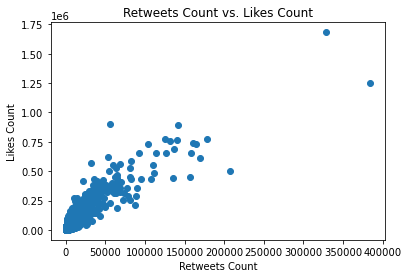

In [43]:
plt.scatter(focus['retweets_count'], focus['likes_count'])
plt.title('Retweets Count vs. Likes Count')
plt.xlabel('Retweets Count')
plt.ylabel('Likes Count');

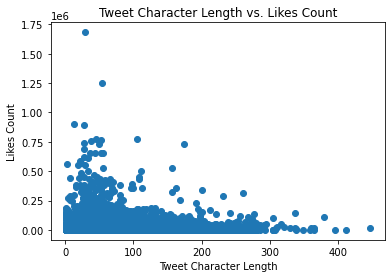

In [44]:
plt.scatter(focus['tweet_char_length'], focus['likes_count'])
plt.title('Tweet Character Length vs. Likes Count')
plt.xlabel('Tweet Character Length')
plt.ylabel('Likes Count');

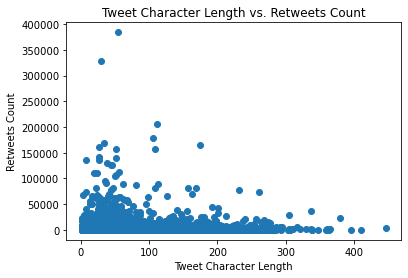

In [45]:
plt.scatter(focus['tweet_char_length'], focus['retweets_count'])
plt.title('Tweet Character Length vs. Retweets Count')
plt.xlabel('Tweet Character Length')
plt.ylabel('Retweets Count');

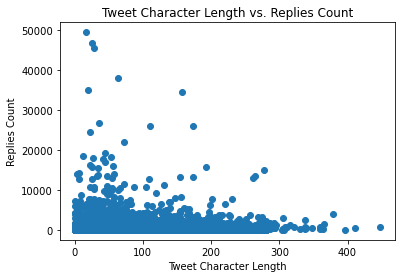

In [46]:
plt.scatter(focus['tweet_char_length'], focus['replies_count'])
plt.title('Tweet Character Length vs. Replies Count')
plt.xlabel('Tweet Character Length')
plt.ylabel('Replies Count');

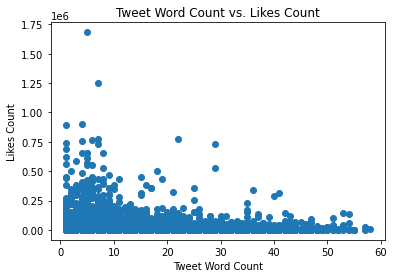

In [47]:
plt.scatter(focus['tweet_word_count'], focus['likes_count'])
plt.title('Tweet Word Count vs. Likes Count')
plt.xlabel('Tweet Word Count')
plt.ylabel('Likes Count');

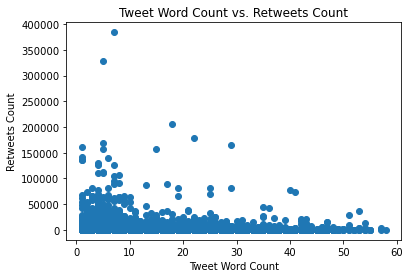

In [48]:
plt.scatter(focus['tweet_word_count'], focus['retweets_count'])
plt.title('Tweet Word Count vs. Retweets Count')
plt.xlabel('Tweet Word Count')
plt.ylabel('Retweets Count');

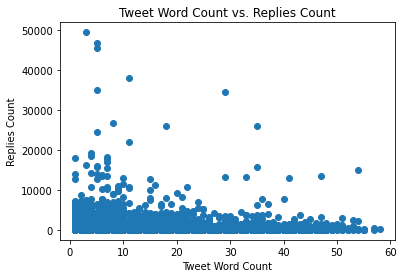

In [49]:
plt.scatter(focus['tweet_word_count'], focus['replies_count'])
plt.title('Tweet Word Count vs. Replies Count')
plt.xlabel('Tweet Word Count')
plt.ylabel('Replies Count');

Maybe do some countvectorizing then linear regression, then move on from there

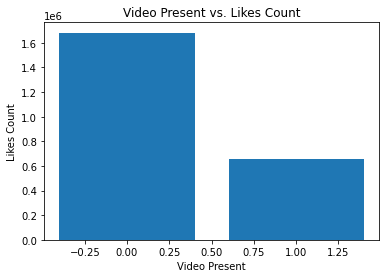

In [50]:
plt.bar(focus['video'], focus['likes_count'])
plt.title('Video Present vs. Likes Count')
plt.xlabel('Video Present')
plt.ylabel('Likes Count');

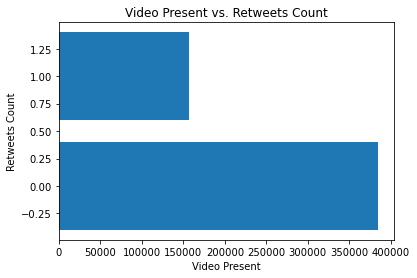

In [51]:
plt.barh(focus['video'], focus['retweets_count'])
plt.title('Video Present vs. Retweets Count')
plt.xlabel('Video Present')
plt.ylabel('Retweets Count');

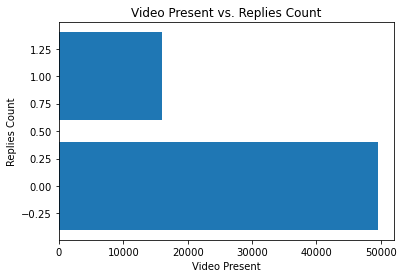

In [52]:
plt.barh(focus['video'], focus['replies_count'])
plt.title('Video Present vs. Replies Count')
plt.xlabel('Video Present')
plt.ylabel('Replies Count');

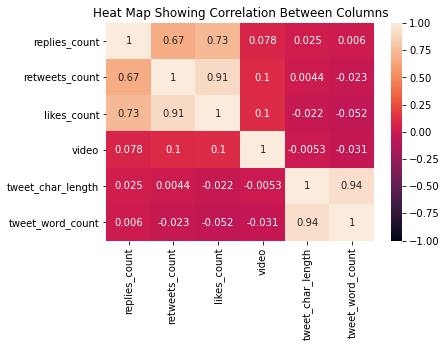

In [53]:
sns.heatmap(focus.corr(), annot = True, vmin = -1)
plt.title('Heat Map Showing Correlation Between Columns');

Bring in the dataset of Elon's tweets from 2012 to 2017, which may possibly be used in conjunction

In [35]:
older = pd.read_csv('data/data_elonmusk.csv', encoding='windows-1252')
older.head()

,row ID,Tweet,Time,Retweet from,User
0,Row0,"@MeltingIce Assuming max acceleration of 2 to 3 g's, but in a comfortable direction. Will feel like a mild to moder? https://t.co/fpjmEgrHfC",2017-09-29 17:39:19,NaN,elonmusk
1,Row1,"RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?",2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,Fly to most places on Earth in under 30 mins and anywhere in under 60. Cost per seat should be? https://t.co/dGYDdGttYd,2017-09-29 09:19:21,NaN,elonmusk


In [36]:
older.shape

(3218, 5)

In [37]:
older.isnull().sum()

row ID             0
Tweet              0
Time               0
Retweet from    2693
User               0
dtype: int64

In [38]:
older[older['Retweet from'].notnull()]['Tweet']

1       RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?
5        RT @SpaceX: Supporting the creation of a permanent, self-sustaining human presence on Mars. https://t.co/kCtBLPbSg8 https://t.co/ra6hKsrOcG
10       RT @SpaceX: Nine years ago today, Falcon 1 became the first privately developed liquid fuel rocket to orbit Earth. https://t.co/Aa0ITkuJET?
13      RT @mayemusk: .@covergirl I'm so excited to say that I'm now officially a COVERGIRL, at 69! Beauty is for all ages. #COVERGIRLMADE https://?
24                RT @MotorTrend: Shocking winner of our latest, World's Greatest Drag Race 7! Maybe even #ludicrous? #WGDR7 https://t.co/ImvNAm2Yop
                                                                            ...                                                                     
3192      RT @Slate: New government study says we could save billions by replacing dollar bills with coins

In [39]:
older = older.drop(columns=['row ID'])

## I may not use this dataset as it does not include engagement, only tweets, though it could be interesting to use this as the testing data, if possible.

In [41]:
focus.to_csv('data/focus.csv', index=False)